<a href="https://colab.research.google.com/github/GodRishUniverse/Deepfake-detect-AIC/blob/main/Learning/Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# test save
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danielaungkhantmoe","key":"80682f47678f298fdd26a784977ccbc1"}'}

In [ ]:
import os

# Create the .kaggle directory if it doesn't exist
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Move the file to the correct directory
!mv kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
!kaggle datasets list -s deepfake

ref                                                              title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  -------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
birdy654/deep-voice-deepfake-voice-recognition                   DEEP-VOICE: DeepFake Voice Recognition              3956840339  2023-08-24 13:12:23.837000          11447        103  1.0              
manjilkarki/deepfake-and-real-images                             deepfake and real images                            1808722718  2022-02-03 15:33:45.663000          30033        121  0.625            
abdallamohamed312/in-the-wild-audio-deepfake                     In The Wild (audio Deepfake)                                 0  2024-04-20 04:28:55.640000           1139         48  1.0          

In [ ]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
 99% 1.67G/1.68G [00:09<00:00, 258MB/s]
100% 1.68G/1.68G [00:09<00:00, 185MB/s]


In [ ]:
!unzip deepfake-and-real-images.zip -d deepfake-and-real-images

Streaming output truncated to the last 5000 lines.
  inflating: deepfake-and-real-images/Dataset/Validation/Real/real_5499.jpg  
  inflating: deepfake-and-real-images/Dataset/Validation/Real/real_55.jpg  
  inflating: deepfake-and-real-images/Dataset/Validation/Real/real_550.jpg  
  inflating: deepfake-and-real-images/Dataset/Validation/Real/real_5500.jpg  
  inflating: deepfake-and-real-images/Dataset/Validation/Real/real_5501.jpg  
  inflating: deepfake-and-real-images/Dataset/Validation/Real/real_5502.jpg  
  inflating: deepfake-and-real-images/Dataset/Validation/Real/real_5503.jpg  
  inflating: deepfake-and-real-images/Dataset/Validation/Real/real_5504.jpg  
  inflating: deepfake-and-real-images/Dataset/Validation/Real/real_5505.jpg  
  inflating: deepfake-and-real-images/Dataset/Validation/Real/real_5506.jpg  
  inflating: deepfake-and-real-images/Dataset/Validation/Real/real_5507.jpg  
  inflating: deepfake-and-real-images/Dataset/Validation/Real/real_5508.jpg  
  inflating: dee

In [7]:
import shutil
import zipfile

# Remove existing folder if it exists
shutil.rmtree("deepfake-and-real-images", ignore_errors=True)

# Extract the ZIP file again
with zipfile.ZipFile("deepfake-and-real-images.zip", "r") as zip_ref:
    zip_ref.extractall("deepfake-and-real-images")

# Confirm extraction
import os
print(os.listdir("deepfake-and-real-images"))

['Dataset']


In [8]:
from pathlib import Path

In [9]:
data_path = Path('deepfake-and-real-images')
image_path = data_path / "Dataset"
train_path = image_path / "Train"
test_path = image_path / "Test"

In [10]:
import random
from PIL import Image
#set seed
#random.seed(42)

#Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

#pick a random image path
random_image_path = random.choice(image_path_list)

In [11]:
image_class = random_image_path.parent.stem

Random Image Path: deepfake-and-real-images/Dataset/Train/Real/real_37056.jpg
Image class: Real
Image Heigh: 256
Image Width: 256


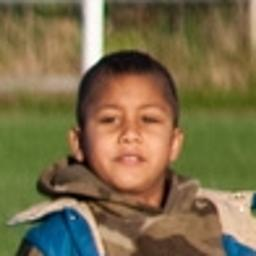

In [12]:
img = Image.open(random_image_path)
#print metadata
print(f'Random Image Path: {random_image_path}')
print(f"Image class: {image_class}")
print(f'Image Heigh: {img.height}')
print(f'Image Width: {img.width}')
img

In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

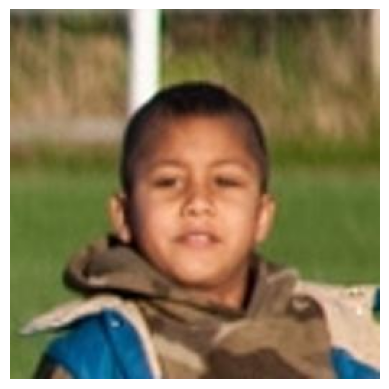

In [14]:
import numpy as np
import matplotlib.pyplot as plt
img_as_array = np.asarray(img)
plt.imshow(img)
plt.axis(False)

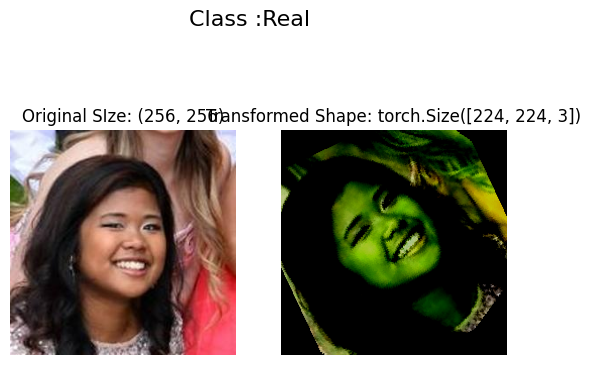

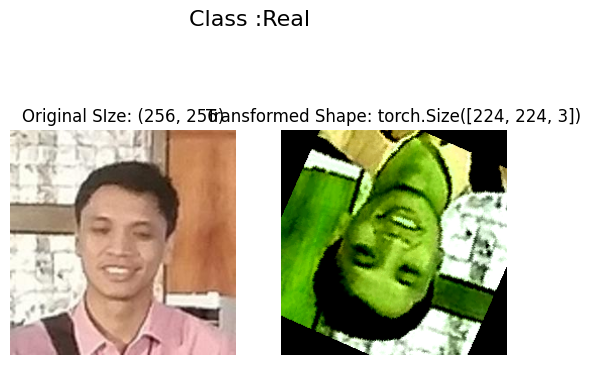

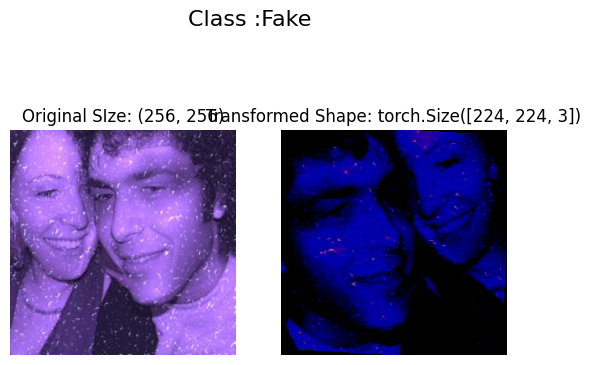

In [34]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
'''
data_transforms = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.RandomCrop(size=(224,224)),
    transforms.ColorJitter(
        brightness = 0.2,
        contrast = 0.2,
        saturation = 0.2,
        hue = 0.2
    ),
    transforms.RandomPerspective(p=0.5),
    transforms.RandomAffine(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])
'''
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),                 # Resize to consistent base size
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Slightly random zoom/crop
    transforms.RandomHorizontalFlip(p=0.5),        # Natural variation
    transforms.ColorJitter(                        # Mild color variation
        brightness=0.1,
        contrast=0.1,
        saturation=0.1,
        hue=0.05
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

def plot_transformed_images(image_paths, transforms, n=3, seed = 42):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original SIze: {f.size}')
      ax[0].axis(False)

      transformed_image = transforms(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed Shape: {transformed_image.shape}')
      ax[1].axis(False)
      fig.suptitle(f'Class :{image_path.parent.stem}', fontsize = 16)
plot_transformed_images(image_path_list, data_transforms)

In [35]:
train_data = datasets.ImageFolder(root = train_path,
                                  transform= data_transforms,
                                  target_transform=None)
test_data = datasets.ImageFolder(root = test_path,
                                 transform = test_transforms)
classes = train_data.classes

In [17]:
train_dataloader = DataLoader(dataset=train_data, batch_size = 8, num_workers=1, shuffle = True) # Reduced batch size to 16
test_dataloader = DataLoader(dataset = test_data, batch_size = 8, num_workers=1, shuffle = False) # Reduced batch size to 16

In [32]:
class DeepfakeDetectionModel(nn.Module):
  def __init__(self, in_features, out_features, hidden_units):
    super().__init__()
    #We need multiple blocks for out data to pass through
    self.block1 = nn.Sequential(
        #First the convuloutional layer
        nn.Conv2d(in_channels=in_features,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride = 1,
                  padding=0),
        nn.BatchNorm2d(hidden_units),  # Add Batch Normalization
        ##ReLU layer
        nn.LeakyReLU(),
        #Maxpool Layer
        nn.MaxPool2d(kernel_size=2,
                     stride = 2))
    #Same block
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride = 1,
                  padding = 0),
        nn.BatchNorm2d(hidden_units),  # Add Batch Normalization
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride = 1,
                  padding = 0),
        nn.BatchNorm2d(hidden_units),  # Add Batch Normalization
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride = 2))

    self.dropout = nn.Dropout(0.4)  # Add dropout to prevent overfitting

    # Dummy forward pass to calculate the flattened size
    dummy_input = torch.randn(1, in_features, 224, 224) # Assuming input image size is 224x224
    dummy_output = self.block1(dummy_input)
    dummy_output = self.block2(dummy_output)
    flattened_size = dummy_output.view(dummy_output.size(0), -1).shape[1]

    self.classifier = nn.Sequential(
        nn.Flatten(),
        # Use the calculated flattened_size for the first linear layer
        nn.Linear(in_features = flattened_size, out_features=out_features),
        nn.LeakyReLU(),
        nn.Dropout(0.5),  # Add another dropout
        nn.Linear(out_features, 2)
    )
  #Forward pass the data through the different layers, and return the final output of x
  def forward(self,x):
      x = self.block1(x)
      x = self.block2(x)
      x = self.dropout(x)
      x = self.classifier(x)
      return x

In [19]:
len(classes)

2

In [20]:
model = DeepfakeDetectionModel(in_features=3, out_features=1, hidden_units=10).to(device)

In [21]:
image_batch, label_batch = next(iter(train_dataloader)) #Create dummy data do find out what the value needs to be for the input shape of our linear layer

In [22]:
image_batch.shape, label_batch.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

In [23]:
model(image_batch.to(device))

tensor([[-0.4432],
        [-0.4432],
        [-0.4432],
        [-0.4653],
        [-0.4514],
        [-0.4432],
        [-0.4115],
        [-0.4432]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [37]:
# Hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 10
STEP_SIZE = 10
GAMMA = 0.1
WEIGHT_DECAY = 1e-5

In [25]:
from torch import nn
from torch import optim

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
# TODO  - change the scheduler accordingly
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = STEP_SIZE, gamma = GAMMA)

In [26]:
def train_one_step(model, dataloader, optimizer, scheduler, loss, device):
  model.train()
  total_loss = 0
  for image_batch, label_batch in dataloader:
    image_batch = image_batch.to(device)
    label_batch = label_batch.to(device)
    pred = model(image_batch)
    loss = loss_fn(pred, label_batch.unsqueeze(1).float())
    total_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
  return total_loss/len(dataloader)

In [27]:
def calculcate_accuracy(pred, true):
  preds = torch.round(torch.sigmoid(pred)) # Apply sigmoid to get probabilities and round to 0 and 1
  accuracy = (preds == true).float().mean() # Compare the results and find the average
  return accuracy

In [28]:
def test(model, dataloader, loss_fn, device):
  model.eval()
  loss = 0
  accuracy = 0
  #Context manager to disable gradient calculation during testing
  with torch.no_grad(): #This will stop pytorch from storing gradients during evaluation
    for image_batch, label_batch in dataloader:
      image_batch = image_batch.to(device)
      label_batch = label_batch.to(device)
      pred = model(image_batch)
      loss += loss_fn(pred, label_batch.unsqueeze(1).float()).item() #Call .item() to move the loss to the CPU and save memory on the GPU
      accuracy += calculcate_accuracy(pred, label_batch) # Calculate the accuracy
  return loss/len(dataloader), accuracy/len(dataloader)

In [29]:
%pip install tqdm

In [30]:
from tqdm.auto import tqdm
def train(model, train_dataloader, test_dataloader, optimizer, scheduler, loss_fn, epochs, device):
  for epoch in tqdm(range(epochs)):
    loss = train_one_step(model, train_dataloader, optimizer, scheduler, loss_fn, device)
    test_loss, accuracy = test(model, test_dataloader, loss_fn, device)
    print(f"Epoch: [{epoch+1}/{epochs}] | Loss: {loss} | Test Loss: {test_loss} | Accuracy: {accuracy}")

In [38]:
# Accuracy added
train(model, train_dataloader, test_dataloader, optimizer, scheduler, loss_fn, EPOCHS, device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: [1/10] | Loss: 0.722833352367249 | Test Loss: 0.7222770428683751 | Accuracy: 0.5032991170883179
Epoch: [2/10] | Loss: 0.7229967117462831 | Test Loss: 0.7221700048341779 | Accuracy: 0.5032991170883179
Epoch: [3/10] | Loss: 0.7228991750117527 | Test Loss: 0.722178720833619 | Accuracy: 0.5032991170883179


KeyboardInterrupt: 